In [ ]:
%pip install numpy pandas scikit-learn matplotlib scipy

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_squared_error, r2_score
from scipy.stats import skew

In [3]:
# Load the data
data = fetch_california_housing()
X, y = data.data, data.target

In [5]:
# Description of the dataset
print(data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [6]:
# Splitting 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# EDA Exploratory Data Analysis
eda = pd.DataFrame(data=X_train)
eda.columns = data.feature_names
eda["MedHouseVal"] = y_train
eda.describe(include="all")

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,3.880754,28.608285,5.435235,1.096685,1426.453004,3.096961,35.643149,-119.582290,2.071947
std,1.904294,12.602499,2.387375,0.433215,1137.056380,11.578744,2.136665,2.005654,1.156226
min,0.499900,1.000000,0.888889,0.333333,3.000000,0.692308,32.550000,-124.350000,0.149990
25%,2.566700,18.000000,4.452055,1.006508,789.000000,2.428799,33.930000,-121.810000,1.198000
50%,3.545800,29.000000,5.235874,1.049286,1167.000000,2.817240,34.260000,-118.510000,1.798500
75%,4.773175,37.000000,6.061037,1.100348,1726.000000,3.280000,37.720000,-118.010000,2.651250
max,15.000100,52.000000,141.909091,25.636364,35682.000000,1243.333333,41.950000,-114.310000,5.000010


Considering the 25th to the 75th percentile range, most of the median house prices fall within $119 800 and $265 125

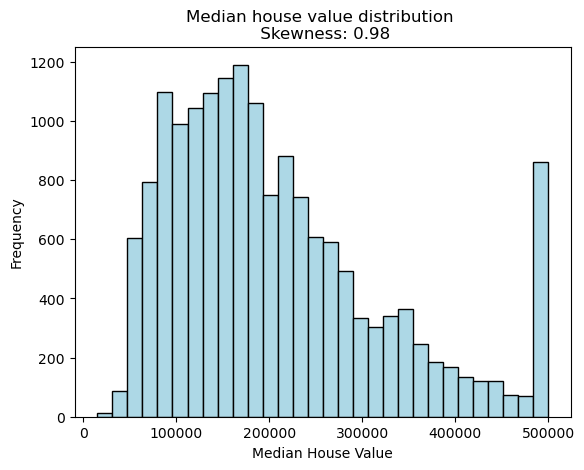

In [14]:
# Plot the distribution
plt.hist(1e5*y_train, bins=30, color="lightblue", edgecolor="black")
plt.title(f"Median house value distribution \n Skewness: {skew(y_train):.2f}")
plt.xlabel("Median House Value")
plt.ylabel("Frequency")
plt.show()

The distribution is skewed and there are quite a few clipped values at around $500 000

## Models fitting and prediction

In [15]:
# Initialize and train Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Predict
y_pred_test = rf_regressor.predict(X_test)

In [19]:
# Estimate out of sample regression metrics
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = root_mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print(f"Mean Absolute Error(MAE): {mae:.4f}")
print(f"Mean Squared Error(MSE): {mse:.4f}") # target: lower MSE, relative lower value
print(f"Root Mean Squared Error(RMSE): {rmse:.4f}")
print(f"R2 Score: {r2:.4f}") # target: Higher r2, close to 1

Mean Absolute Error(MAE): 0.3275
Mean Squared Error(MSE): 0.2554
Root Mean Squared Error(RMSE): 0.5053
R2 Score: 0.8051


Taking in consideration the scale 1e5, the mean absolute error is $32 750.
So, on average, predicted median house prices are off by $33k. <br/><br/>
MSE is less intuitive to interpret, but is usually what is being minimized by the model fit.<br/>
The RMSE yields a dollar value, here RMSE= $50 530.<br/><br/>
An R2 score of 0.80 is not considered very high. It means the model explains about 80% of the variance in the median house prices, although this interpretation can be misleading for complex data with non linear relationships, **skewed values**, and outliers. R-squared can still be useful for comparing models though. <br/>

We need more details about the performance of the model.

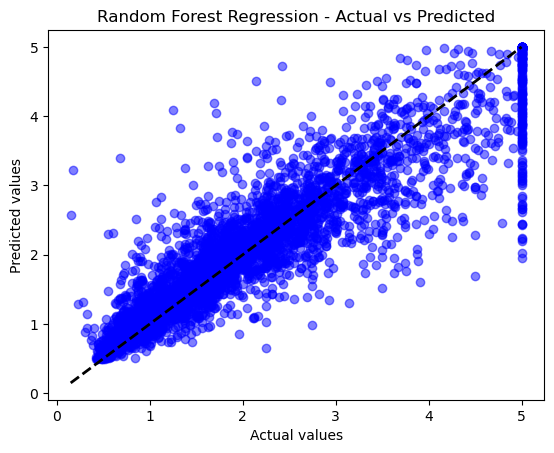

In [23]:
# Visualize
plt.scatter(y_test, y_pred_test, alpha=0.5, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Random Forest Regression - Actual vs Predicted")
plt.show()

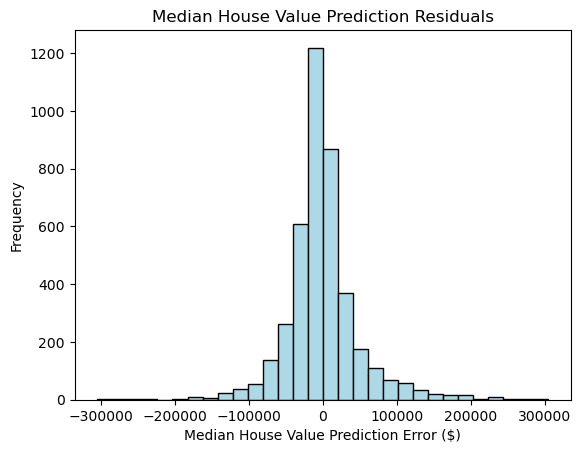

Average Error = -1242
Standard Deviation of Error = 50518


In [33]:
# Plot the histograms of the residual errors (in $)
residuals = 1e5*(y_test - y_pred_test)

plt.hist(residuals, bins=30, color="lightblue", edgecolor="black")
plt.title("Median House Value Prediction Residuals")
plt.xlabel("Median House Value Prediction Error ($)")
plt.ylabel("Frequency")
plt.show()
print(f"Average Error = {str(int(np.mean(residuals)))}")
print(f"Standard Deviation of Error = {str(int(np.std(residuals)))}")


The residuals are normally distributed with a very small average error and a standard deviation of about $50k

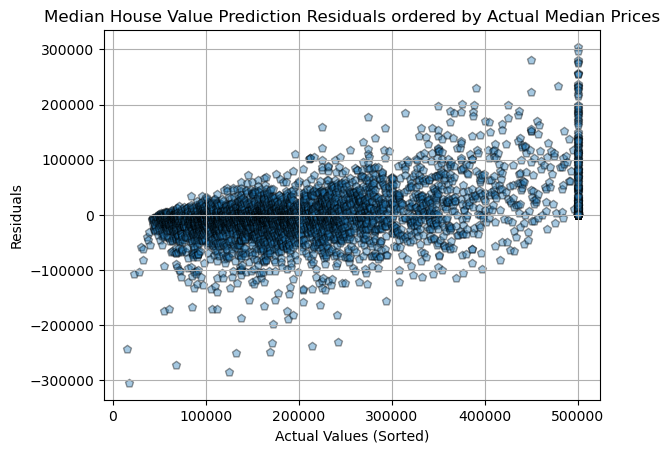

In [34]:
# Plot the model residuals error by median house value
residual_df = pd.DataFrame({
    "Actual": 1e5*y_test,
    "Residuals": residuals
})

residual_df = residual_df.sort_values(by="Actual")

# Plot
plt.scatter(residual_df["Actual"], residual_df["Residuals"], marker="p", alpha=0.4, ec="k")
plt.title("Median House Value Prediction Residuals ordered by Actual Median Prices")
plt.xlabel("Actual Values (Sorted)")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

Although we saw a small average residual of only -$1200, u can see from this plot that the average error as a function of median house price is actually increasing from negative to positive values. <br/>
In other words, lower median prices trend to be over predicted while higher median prices tend to be under predicted

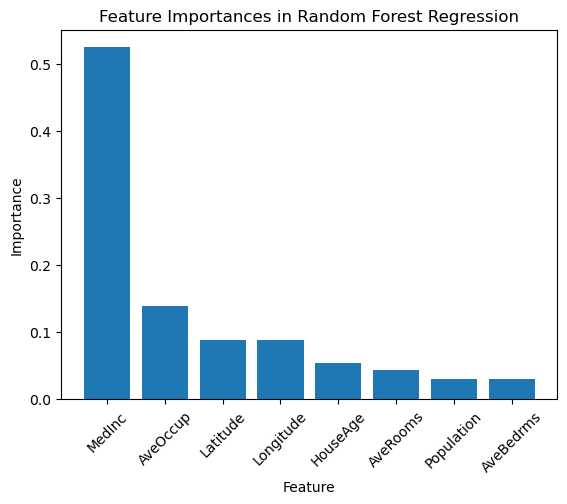

In [38]:
# Display the features importance as a bar chart
importances = rf_regressor.feature_importances_
indices = np.argsort(importances)[::-1]
features = data.feature_names

# plot
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importances in Random Forest Regression")
plt.show()

It's not surprising that median income is the most important feature due to the correlation. <br/>
I would think that location must be a significant factor. Since location is implied by two separated variables, latitude and longitude that share equal importances, we might speculate that locations is really the second most important feature. This is because replacing lat and lng with a categorical location at an appropriated level of granularity (city, region, etc) would likely have a combined lat/lng importance, which might outweigh average occupancy. <br/>

Might average occupancy and average number of bedrooms be correlated? A proper analysis of the feature set would include a correlation matrix

### Some final thoughts to consider
- Q: Will the skewness affect the performance of Random Forest Regression?
    - A: Compared to Linear Regression, Random Forest is quite robust against outliers and skewed distributions. This is because random forest regression doesn't make any assumptions about the data distributions, where linear regression performs better with normally distributed data.
- Q: Does the clipping of median house prices above $500 000 bias the predictions?
    - A: Regarding clipped values, there is no variability in those values. Removing them in pre processing might help the model to better explain the actual variance of the data. The clipped values can also bias the predictions. Also these clipped valued can mislead evaluation metrics. It's crucially important to visualize your results.
- Q: Do we need to standardize the data?
    - A: It isn't necessary like it is for distance-based algorithms like KNN or SVMs